#### Problem Statement
Banks face significant challenges in retaining their customers, as customer churn directly impacts profitability and operational efficiency. Customer churn in the banking sector occurs when customers close their accounts or switch to competitors, often due to dissatisfaction with services, lack of engagement, or more attractive offerings elsewhere.

The objective of this project is to analyze and predict customer churn for a bank using historical data. The dataset includes features such as customer demographics, account balance, credit score, tenure with the bank, and usage patterns of banking services.

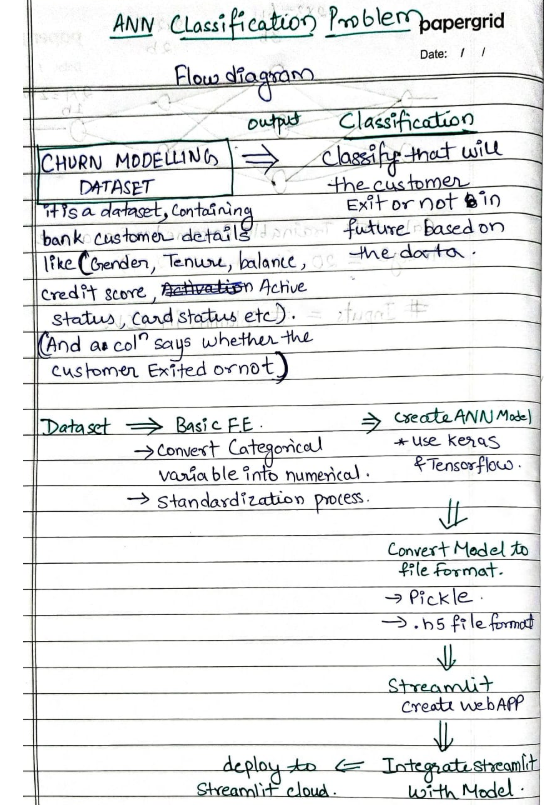

### Step1: Preprocessing of dataset

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

In [4]:
df=pd.read_csv('../Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


remove the unnecessary columns 

In [5]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


changing the text columns to numerical data for gender 

#### Why can't use label encoding for Geography?
We cannot use Label Encoding for features like "Geography" because it assigns numerical integers directly to each category. For example, it might assign 0 to "France," 1 to "Italy," and 2 to "Germany." Since Artificial Neural Networks (ANNs) operate on numerical values, they may mistakenly interpret these numbers as indicating an order or importance (e.g., "Germany" > "Italy" > "France"). This interpretation is incorrect, as these categories are not having any ranking.

To avoid this issue and ensure that each category is treated equally, we use One-Hot Encoding.

In [6]:
labelencoder=LabelEncoder()
df['Gender']=labelencoder.fit_transform(df['Gender'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


The double brackets [['Geography']] are used to return a DataFrame with that single column, rather than a Series.

In [7]:
onehotencoder=OneHotEncoder()
geo_encoder=onehotencoder.fit_transform(df[['Geography']])
geo_encoder

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10000 stored elements and shape (10000, 3)>

##### Problem
- The output of OneHotEncoder.fit_transform() is a sparse matrix (by default).
- When you try to create a Pandas DataFrame directly from this sparse matrix: Pandas will not interpret the sparse matrix properly, and it assumes there is only 1 column, causing error: ValueError: Shape of passed values is (10000, 1), indices imply (10000, 3)

##### Solution:
- Convert to numpy array
- Pandas automatically understands the shape of the NumPy array and creates a DataFrame where each row corresponds to a row in the NumPy array, and each column corresponds to a column in the array.

In [8]:
geo_encoder=geo_encoder.toarray()
onehotencoder.get_feature_names_out(['Geography'])

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [9]:
df_geo=pd.DataFrame(geo_encoder,columns=onehotencoder.get_feature_names_out(['Geography']))
df_geo.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


removing the old geography column and combining the geo df with original df

In [10]:
df=pd.concat([df.drop(['Geography'],axis=1),df_geo],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


### Step2: Store the data in pickle file and segregating data

In [12]:
with open('labelencoder.pkl','wb') as file:
    pickle.dump(labelencoder,file)

with open('onehotencoder.pkl','wb') as file:
    pickle.dump(onehotencoder,file)

In [15]:
X=df.drop(['Exited'],axis=1)
Y=df['Exited']

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)